# Implement precipitation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re, os
import numpy as np
import xarray as xr
import tensorflow.keras as keras
import datetime
import pdb
import matplotlib.pyplot as plt
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *
import cartopy.crs as ccrs
import seaborn as sns
from src.regrid import *

## Figure out which CMIP precip to download

In [3]:
era = xr.open_dataset('/data/stephan/WeatherBench/5.625deg/total_precipitation/total_precipitation_1979_5.625deg.nc')

In [4]:
ds = xr.open_dataset('/data/stephan/WeatherBench/CMIP/test/pr_6hrPlev_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_185001010300-185412312100.nc')

In [5]:
ds2 = xr.open_dataset('/data/stephan/WeatherBench/CMIP/test/pr_3hr_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_185001010130-185412312230.nc')

In [6]:
pr = regrid(ds.pr, 5.625)

Reuse existing file: bilinear_192x384_32x64_peri.nc


In [7]:
pr2 = regrid(ds2.pr, 5.625)

Reuse existing file: bilinear_192x384_32x64_peri.nc


In [8]:
pr = pr / 997 * 60 * 60
pr2 = pr2 / 997 * 60 * 60

In [22]:
pr.time

<xarray.DataArray 'time' (time: 7304)>
array(['1850-01-01T03:00:00.000000000', '1850-01-01T09:00:00.000000000',
       '1850-01-01T15:00:00.000000000', ..., '1854-12-31T09:00:00.000000000',
       '1854-12-31T15:00:00.000000000', '1854-12-31T21:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1850-01-01T03:00:00 ... 1854-12-31T21:00:00
Attributes:
    bounds:         time_bnds
    axis:           T
    long_name:      time
    standard_name:  time

In [24]:
pr.time.rolling(time=2, center=True).mean()

UFuncTypeError: ufunc 'add' cannot use operands with types dtype('<M8[ns]') and dtype('<M8[ns]')

In [13]:
pr.time[:3].values

array(['1850-01-01T03:00:00.000000000', '1850-01-01T09:00:00.000000000',
       '1850-01-01T15:00:00.000000000'], dtype='datetime64[ns]')

In [14]:
pr2.time[:3].values

array(['1850-01-01T01:30:00.000000000', '1850-01-01T04:30:00.000000000',
       '1850-01-01T07:30:00.000000000'], dtype='datetime64[ns]')

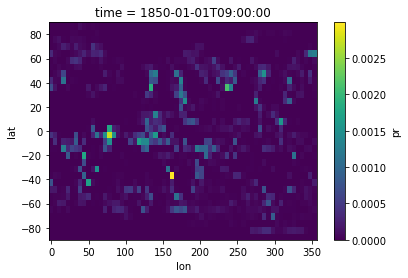

In [16]:
pr.isel(time=1).plot()

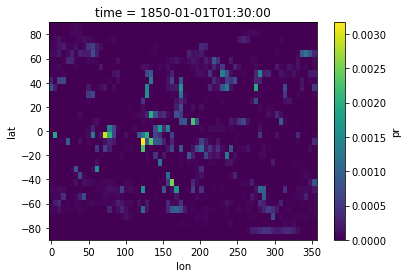

In [10]:
pr2.isel(time=0).plot()

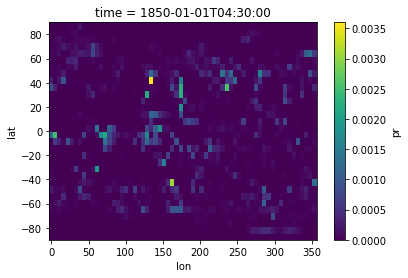

In [15]:
pr2.isel(time=1).plot()

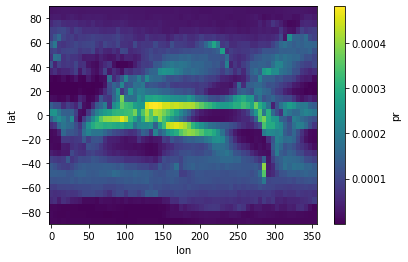

In [19]:
pr.mean('time').plot()

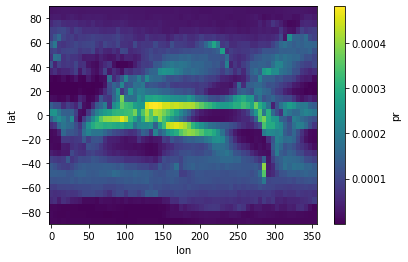

In [17]:
pr2.mean('time').plot()

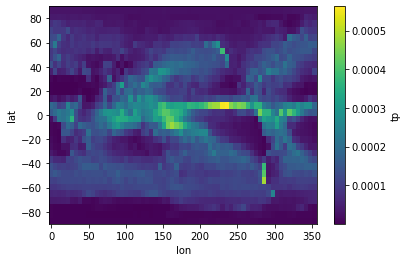

In [21]:
era.tp.mean('time').plot()

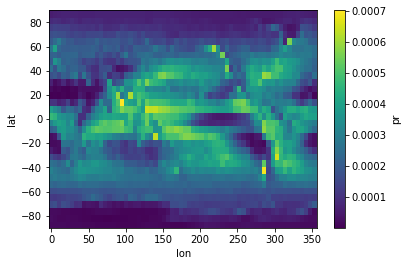

In [22]:
pr.std('time').plot()

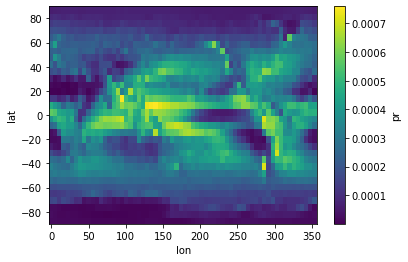

In [18]:
pr2.std('time').plot()

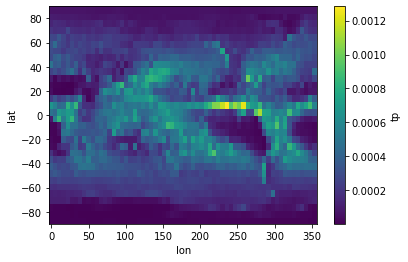

In [23]:
era.tp.std('time').plot()

## convert ERA and CMIP to 6hr aggregations

### ERA

In [39]:
datadir = '/data/stephan/WeatherBench/5.625deg/total_precipitation//'

In [40]:
ds_in = xr.open_mfdataset(f'{datadir}/*.nc', combine='by_coords')

In [41]:
ds_out = ds_in.rolling(time=6, center=False, keep_attrs=True).sum()

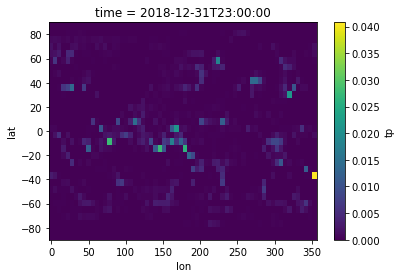

In [42]:
ds_out.tp.isel(time=-1).plot()

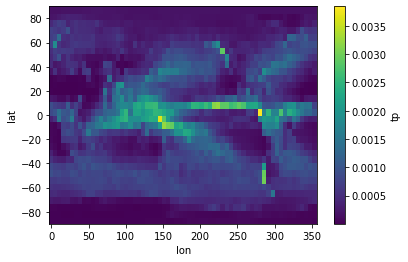

In [45]:
ds_out.tp.sel(time=slice('2017', '2017', )).mean('time').plot()

### CMIP

In [46]:
datadir = '/data/stephan/WeatherBench/CMIP/MPI-ESM/5.625deg/precipitation_flux/'

In [47]:
ds_in = xr.open_mfdataset(f'{datadir}/*.nc', combine='by_coords')

In [48]:
dt = ds_in.time.diff('time')[0].values / np.timedelta64(1, 'h')
dt

6.0

In [49]:
ds_in

,Array,Chunk
Bytes,1.97 GB,59.87 MB
Shape,"(241060, 32, 64)","(7308, 32, 64)"
Count,99 Tasks,33 Chunks
Type,float32,numpy.ndarray


In [50]:
ds_out = ds_in.assign_coords({'time': ds_in['time'] + np.timedelta64(int(dt/2), 'h')})

In [51]:
ds_out.pr.values = ds_out.pr / 997 * 60 * 60 * 6

In [52]:
ds_out

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 241060)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 1850-01-01T06:00:00 ... 2015-01-01
Data variables:
    pr       (time, lat, lon) float32 1.8561095e-06 ... 1.1511165e-08

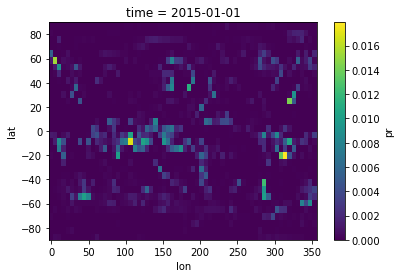

In [53]:
ds_out.pr.isel(time=-1).plot()

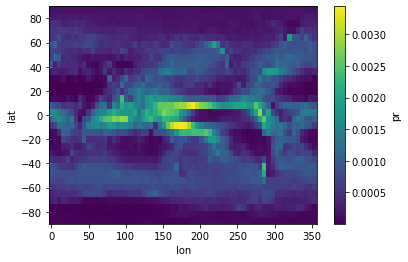

In [56]:
ds_out.pr.sel(time=slice('2014', '2014', )).mean('time').plot()

In [71]:
ds = xr.open_mfdataset('/data/stephan/WeatherBench/5.625deg/2m_temperature_daily/*.nc', 
                       combine='by_coords')

ValueError: Resulting object does not have monotonic global indexes along dimension time

In [73]:
ds1 = xr.open_dataset('/data/stephan/WeatherBench/5.625deg/2m_temperature_daily/2m_temperature_daily_1979_5.625deg.nc')

In [77]:
ds2 = xr.open_dataset('/data/stephan/WeatherBench/5.625deg/2m_temperature_daily/2m_temperature_daily_1980_5.625deg.nc')

In [78]:
ds2

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 17544)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 1980-01-01 ... 1981-12-31T23:00:00
Data variables:
    t2m      (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-07 07:51:20 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

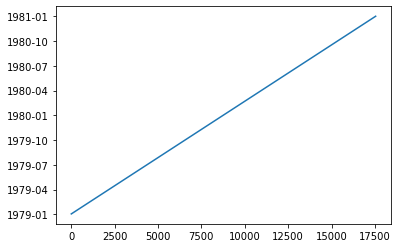

In [76]:
plt.plot(np.arange(len(ds1.time)), ds1.time)

## Data generator

In [81]:
args = load_args('../nn_configs/B/138-resnet_prec.yml')

In [82]:
args['train_years'] = ['2015', '2015']
args['data_subsample'] = 6

In [104]:
dg_train, dg_valid, dg_test = load_data(**args)

In [105]:
X, y = dg_train[0]

In [90]:
dg_train.output_idxs

[35]

In [93]:
'tp' in dg_train.data.level_names

True

In [95]:
list(dg_train.data.level_names).index('tp')

35

## Model --> relu

In [158]:
class ChannelReLU2D(tf.keras.layers.Layer):
    def __init__(self, relu_idxs, **kwargs):
        super().__init__(**kwargs)
        self.relu_idxs = relu_idxs if type(relu_idxs) is list else [relu_idxs]

    def call(self, inputs, **kwargs):
        if inputs.shape[-1] == len(self.relu_idxs):
            return tf.nn.relu(inputs)
        else:
            channels = [inputs[..., i] for i in range(inputs.shape[-1])]
            for i, t in enumerate(channels):
                if i in self.relu_idxs:
                    channels[i] = tf.nn.relu(t)
            return tf.stack(channels, -1)

    def get_config(self):
        config = super().get_config()
        config.update({'relu_idxs': self.relu_idxs})
        return config

In [159]:
def build_resnet(filters, kernels, input_shape, bn_position=None, use_bias=True, l2=0,
                 skip=True, dropout=0, activation='relu', long_skip=False, relu_idxs=None,
                 **kwargs):
    x = input = Input(shape=input_shape)

    # First conv block to get up to shape
    x = ls = convblock(
        x, filters[0], kernels[0], bn_position=bn_position, l2=l2, use_bias=use_bias,
        dropout=dropout, activation=activation
    )

    # Resblocks
    for f, k in zip(filters[1:-1], kernels[1:-1]):
        x = resblock(x, f, k, bn_position=bn_position, l2=l2, use_bias=use_bias,
                dropout=dropout, skip=skip, activation=activation)
        if long_skip:
            x = Add()([x, ls])

    # Final convolution
    output = PeriodicConv2D(
        filters[-1], kernels[-1],
        conv_kwargs={'kernel_regularizer': regularizers.l2(l2)},
    )(x)
    if not relu_idxs is None:
        output = ChannelReLU2D(relu_idxs)(output)
    output = Activation('linear', dtype='float32')(output)
    return keras.models.Model(input, output)

In [160]:
model = build_resnet([10, 1], [3, 3], (32, 64, 1), relu_idxs=[0])

In [161]:
t = model(np.ones((1, 32, 64, 1)))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [163]:
t[..., 0].numpy().min()

0.0

## Evaluate model

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(6)
limit_mem()

In [4]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [6]:
args = load_args('../nn_configs/B/138-resnet_prec.yml')

In [7]:
valid = xr.open_mfdataset(f'{args["datadir"]}/6hr_precipitation/*.nc',combine='by_coords')

In [10]:
preds = xr.open_dataset('~/data/myWeatherBench/predictions/138-resnet_prec.nc').load()

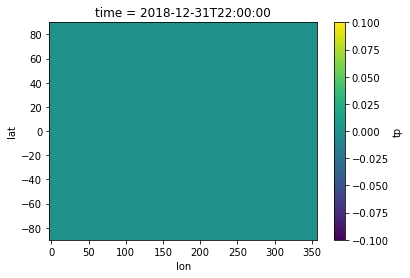

In [14]:
preds.tp.isel(time=-1).plot()

In [17]:
args['ext_mean'] = xr.open_dataarray(f'{args["model_save_dir"]}/{args["exp_id"]}_mean.nc')
args['ext_std'] = xr.open_dataarray(f'{args["model_save_dir"]}/{args["exp_id"]}_std.nc')

In [19]:
args['train_years'] = ['2015', '2015']

In [20]:
dg_train, dg_valid, dg_test = load_data(**args)

In [22]:
X, y = dg_train[0]

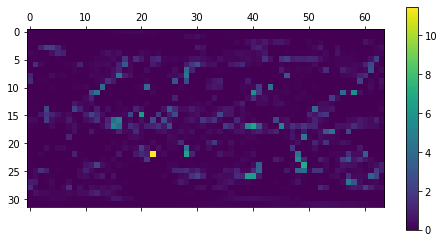

In [54]:

plt.matshow(X[2, ..., -4])
plt.colorbar()

In [24]:
y.shape

(32, 32, 64, 1)

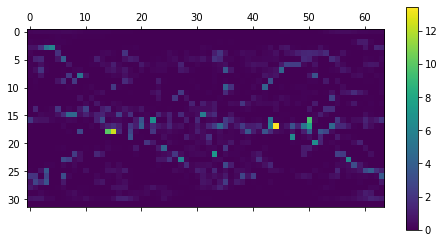

In [55]:
plt.matshow(y[2, ..., 0])
plt.colorbar()

In [26]:
model = load_model(args)

In [34]:
p = model(X**2)

In [35]:
p.numpy().mean()

0.0

In [43]:
model2 = build_resnet(args['filters'], args['kernels'], dg_train.shape, activation='leakyrelu', relu_idxs=0)

In [44]:
model2(X)

<tf.Tensor: shape=(32, 32, 64, 1), dtype=float32, numpy=
array([[[[ 78.75    ],
         [ 84.75    ],
         [ 85.75    ],
         ...,
         [ 79.1875  ],
         [ 78.      ],
         [ 77.0625  ]],

        [[165.625   ],
         [165.875   ],
         [168.375   ],
         ...,
         [168.375   ],
         [165.5     ],
         [163.5     ]],

        [[191.75    ],
         [188.875   ],
         [185.      ],
         ...,
         [193.125   ],
         [195.125   ],
         [191.625   ]],

        ...,

        [[101.5     ],
         [101.625   ],
         [ 91.8125  ],
         ...,
         [126.5     ],
         [122.3125  ],
         [111.75    ]],

        [[ 61.375   ],
         [ 57.78125 ],
         [ 57.5625  ],
         ...,
         [ 65.1875  ],
         [ 66.375   ],
         [ 60.03125 ]],

        [[ 38.1875  ],
         [ 37.75    ],
         [ 35.0625  ],
         ...,
         [ 40.59375 ],
         [ 40.75    ],
         [ 39.21875 ]]],


   